## Import Custom Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


'''
Benchmark 1: custom_env_b1
The agent set an interval of 50 width, and did not reset the interval at all
'''
# from custom_env_folder.custom_env_b1 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 2: custom_env_b2
The agent set an interval of 10 width, and moved the interval (or not) every 10 hours
DO NOT RESET INTERVAL even if price is out of range
'''
# from custom_env_folder.custom_env_b2 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 2: custom_env_b2_1
The agent set an interval of 10 width, and moved the interval (or not) every 10 hours
If the price is out of range every 10 hours, while action is 0, 
reset the interval based on current market price, with 10-width interval
'''
# from custom_env_folder.custom_env_b2_1 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 3: custom_env_b3
The agent set an interval of 10 width, and moved the interval (or not) every 24 hours
DO NOT RESET INTERVAL even if price is out of range
'''
# from custom_env_folder.custom_env_b3 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 3: custom_env_b3_1
The agent set an interval of 10 width, and moved the interval (or not) every 24 hours
If the price is out of range every 24 hours, while action is 0, 
reset the interval based on current market price, with 10-width interval
'''
# from custom_env_folder.custom_env_b3_1 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 4: custom_env_b4
The agent set an interval of 10 width, and moved the interval (or not) every 1 hour
DO NOT RESET INTERVAL even if price is out of range
The action space is width [0, 5, 10, 15]
'''
# from custom_env_folder.custom_env_b4 import CustomMLPFeatureExtractor, Uniswapv3Env
'''
Benchmark 5: custom_env_b_narrow
The agent set an interval of 1 width, and moved the interval (or not) every 1 hour
If the price is out of range while action is 0, 
reset the interval based on current market price, with 1-width interval
The action space is width [0, 1, 3, 5]
'''
# from custom_env_folder.custom_env_b_narrow import CustomMLPFeatureExtractor, Uniswapv3Env

'''
Our LP Agent: custom_env_4
The agent set an interval of 10 width, and moved the interval (or not) every 1 hour
If the price is out of range while action is 0, 
reset the interval based on current market price, with 10-width interval
The action space is width [0, 5, 10, 15]
'''
# from custom_env_folder.custom_env_std import CustomMLPFeatureExtractor, Uniswapv3Env


from custom_env_folder.custom_env_new_lvr import CustomMLPFeatureExtractor, Uniswapv3Env

## Import Market Data

In [2]:
# import market data
uni_data = pd.read_csv('data_price_uni_h.csv')
np.std(uni_data)

split_index = len(uni_data) // 5 * 4

uni_train = uni_data.iloc[0:split_index]
uni_test = uni_data.iloc[split_index:]

# Reset the index of the test data
uni_test.reset_index(drop=True, inplace=True)

# Verify the data

print(uni_train.head())
print(uni_test.head())


     price
0  3296.08
1  3296.08
2  3296.08
3  3296.08
4  3296.08
       price
0  1596.7682
1  1596.8088
2  1587.2426
3  1587.2263
4  1596.7766


/Applications/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


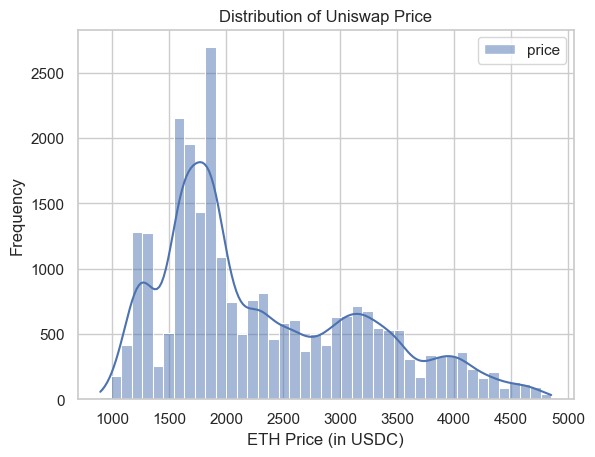

In [3]:
# plot the data
# Set the style of seaborn plot
sns.set_theme(style='whitegrid')

# Create a histogram with a kernel density estimate (KDE)
sns.histplot(uni_data, kde=True)

# Add labels and title
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Frequency')
plt.title('Distribution of Uniswap Price')

# Show the plot
plt.show()

## Setup Environment

In [4]:
# setup environment

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# pass n_steps

uni_env = Uniswapv3Env(delta=0.05, n_actions=4, market_data=uni_train, x=2, gas=20)

action = 1
uni_env.reset()
uni_env.step(action)

# Define policy_kwargs with the custom feature extractor
policy_kwargs = dict(
    features_extractor_class=CustomMLPFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),  # This dimension will be the output of the feature extractor
)

# Create the PPO model with the custom MLP policy and feature extractor
rlmodel = PPO("MlpPolicy", uni_env, n_steps=len(uni_env.market_data) // 10, policy_kwargs=policy_kwargs, verbose=2)


p_u:  3328.890975231183  p_l:  3262.977780263077
Initial x:  15
Initial liquidity:  174312.836287775
Initial y:  50379.63582864693
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Applications/anaconda3/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2094`, after every 32 untruncated mini-batches, there will be a truncated mini-batch of size 46
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2094 and n_envs=1)
  warnings.warn(


## Training

In [5]:
# Train the model
rlmodel.learn(total_timesteps=1e+5)

# update the policy every 100 steps until it reaches 10000


rlmodel.save("ppo_custom_env")

# Test the trained model
# obs, _ = uni_env.reset()
# for _ in range(20):
#     action, _states = rlmodel.predict(obs, deterministic=False)
#     obs, rewards, done, truncated, info = uni_env.step(action)
#     print(f'Action taken: {action}')
#     print(f'Next State: {obs}')
#     print(f'Reward: {rewards}\n')

p_u:  3312.2888902438453  p_l:  3279.3327046717786
Initial x:  15
Initial liquidity:  351535.0906592234
Initial y:  51338.468533633204
97 Truncated here 0.007269898275580478 Liquidity
p_u:  3328.890975231183  p_l:  3262.977780263077
Initial x:  15
Initial liquidity:  174312.836287775
Initial y:  50379.63582864693
54 Truncated here 0.008545324678332925 Liquidity
p_u:  3345.5762743447813  p_l:  3246.7044223120974
Initial x:  15
Initial liquidity:  115985.90686066775
Initial y:  50064.06729175771
159 Truncated here 0.008768046732629656 Liquidity
p_u:  3312.2888902438453  p_l:  3279.3327046717786
Initial x:  15
Initial liquidity:  351535.0906592234
Initial y:  51338.468533633204
166 Truncated here 0.0060636066871600615 Liquidity
p_u:  3345.5762743447813  p_l:  3246.7044223120974
Initial x:  15
Initial liquidity:  115985.90686066775
Initial y:  50064.06729175771
120 Truncated here 0.002739547752444976 Liquidity
p_u:  3328.890975231183  p_l:  3262.977780263077
Initial x:  15
Initial liquidit

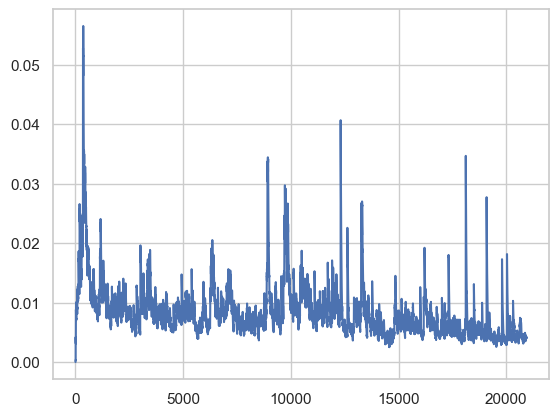

In [6]:
plt.plot(uni_env.ew_sigma)

In [7]:
log_returns = np.log(uni_env.market_data[1:] / uni_env.market_data[:-1])

sigma = np.std(log_returns)
sigma

0.009555428

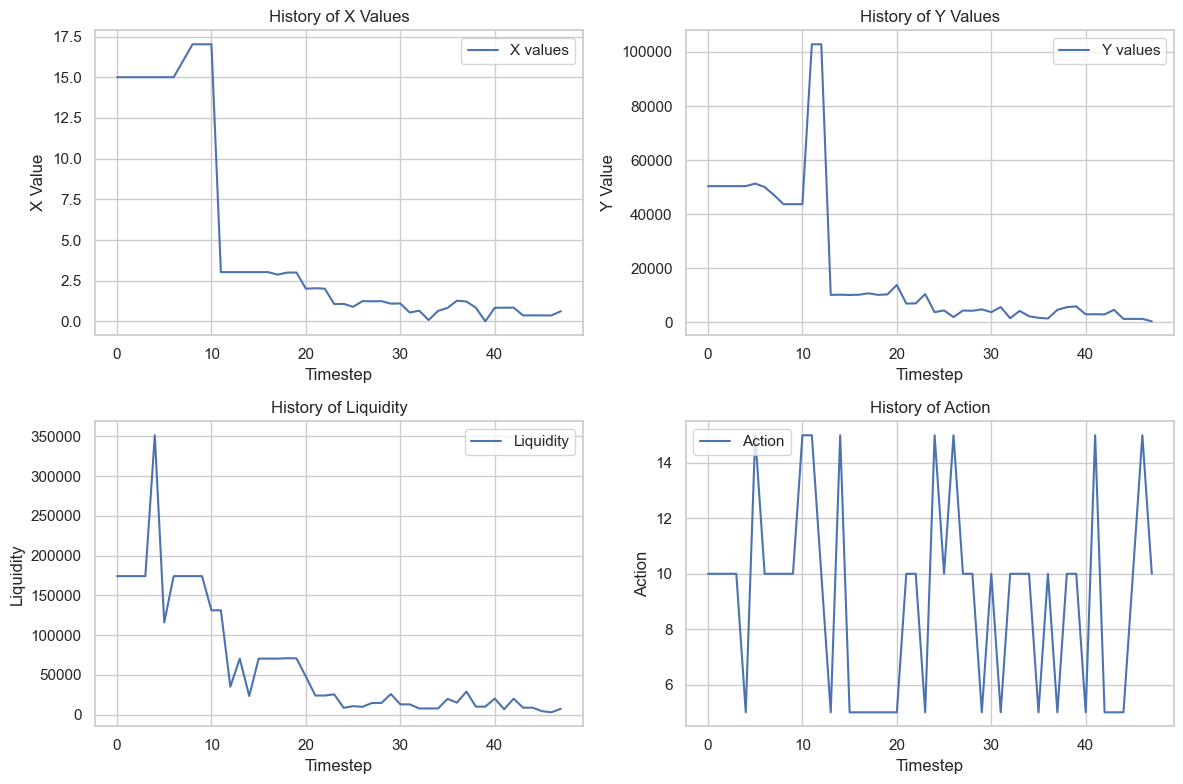

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(uni_env.x_history[0:200], label='X values')
plt.title('History of X Values')
plt.xlabel('Timestep')
plt.ylabel('X Value')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(uni_env.y_history[0:200], label='Y values')
plt.title('History of Y Values')
plt.xlabel('Timestep')
plt.ylabel('Y Value')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(uni_env.l_history, label='Liquidity')
plt.title('History of Liquidity')
plt.xlabel('Timestep')
plt.ylabel('Liquidity')
plt.legend()

plt.subplot(2, 2, 4)
# plt.plot(uni_env.action_history[0:200], 'o', label='Action')
plt.plot(uni_env.action_history[0:100], label='Action')
plt.title('History of Action')
plt.xlabel('Timestep')
plt.ylabel('Action')
plt.legend()

plt.tight_layout()
plt.show()

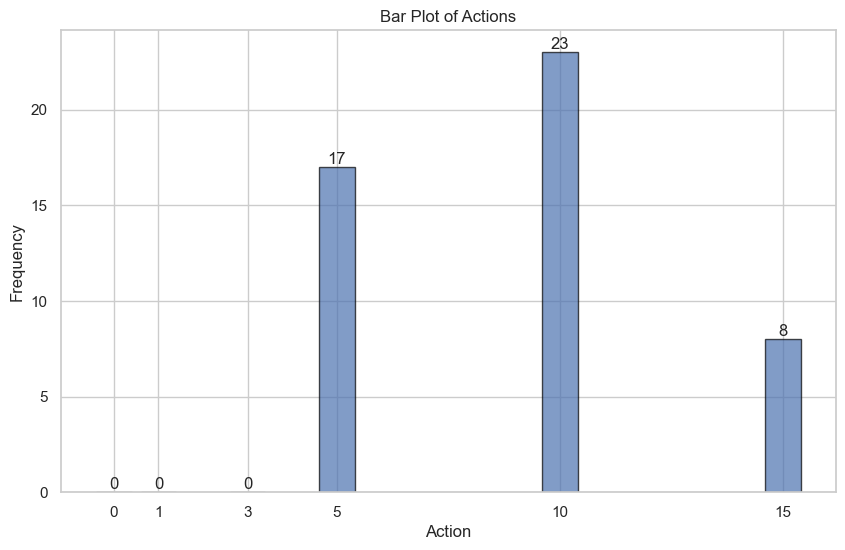

In [9]:
# Histogram for Actions (with price out correction)
action_counts = [uni_env.action_history.count(action) for action in [0, 1, 3, 5, 10, 15]]

actions = [0, 1, 3, 5, 10, 15]

plt.figure(figsize=(10, 6))
bars = plt.bar(actions, action_counts, edgecolor='black', alpha=0.7)

for bar, count in zip(bars, action_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Bar Plot of Actions')
plt.xticks(actions) 

plt.show()

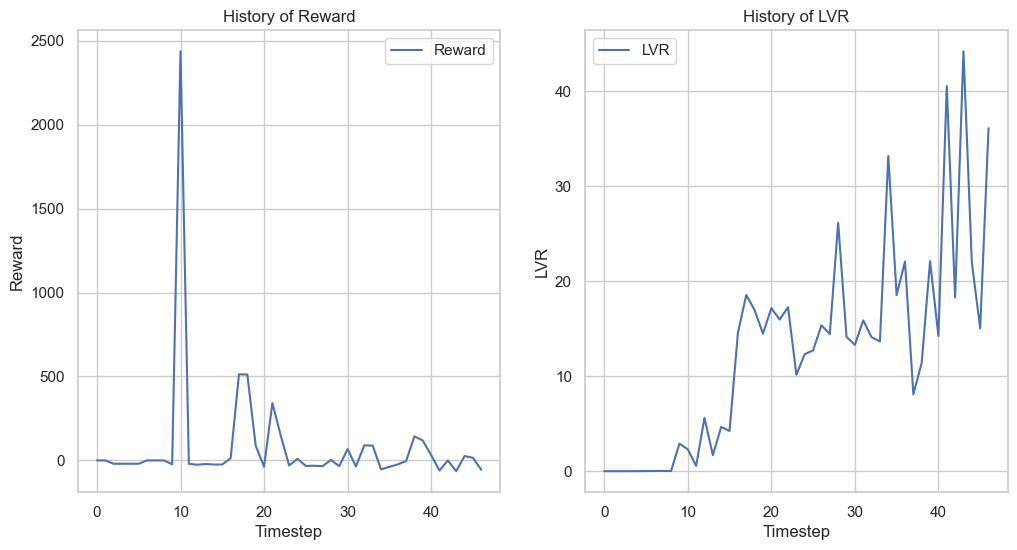

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(uni_env.reward_history[0:200], label='Reward')
plt.title('History of Reward')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(uni_env.lvr_history[0:200], label='LVR')
plt.title('History of LVR')
plt.xlabel('Timestep')
plt.ylabel('LVR')
plt.legend()


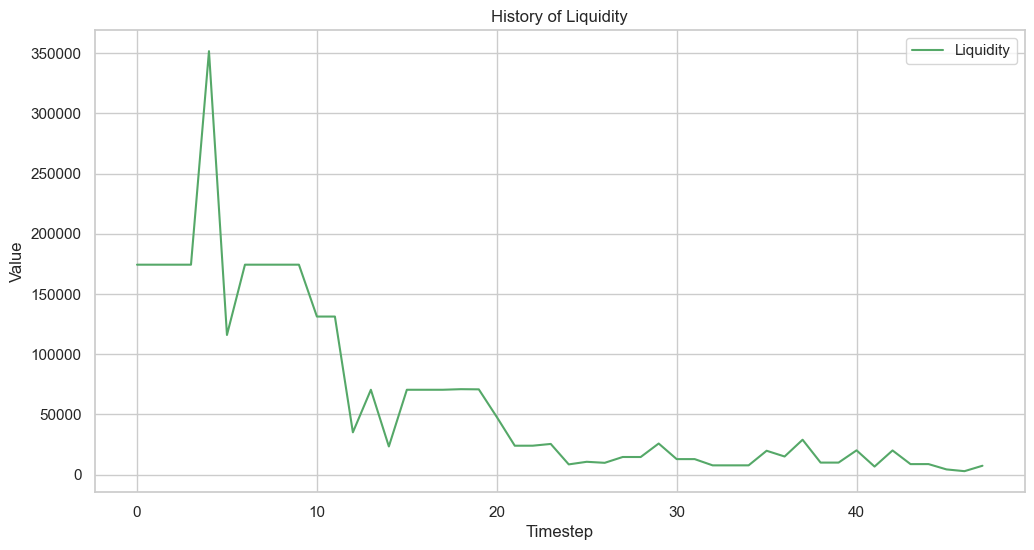

In [11]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(uni_env.l_history[0:200], label='Liquidity', color='g')


# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Liquidity')

# Add legend
plt.legend()

plt.show()

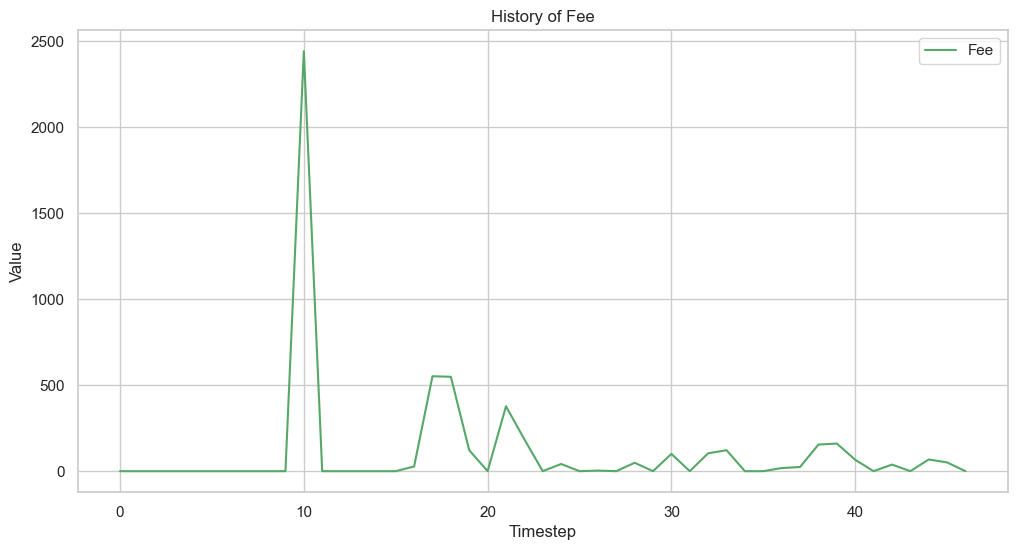

In [12]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(uni_env.fee_history[0:200], label='Fee', color='g')


# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Fee')

# Add legend
plt.legend()

plt.show()

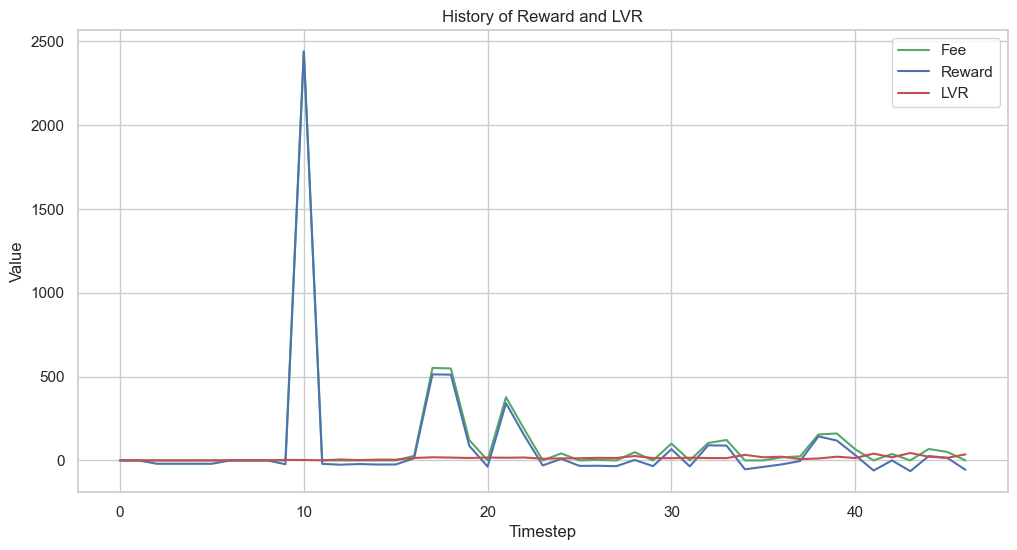

In [13]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(uni_env.fee_history[0:300], label='Fee', color='g')

# Plot reward history
plt.plot(uni_env.reward_history[0:300], label='Reward', color='b')

# Plot LVR history
plt.plot(uni_env.lvr_history[0:300], label='LVR', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Reward and LVR')

# Add legend
plt.legend()

plt.show()

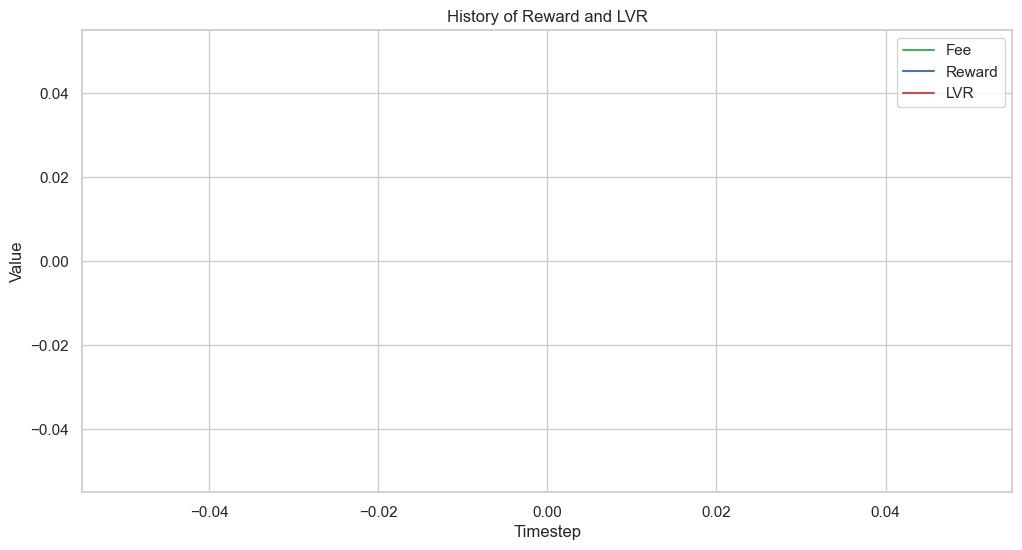

In [14]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(uni_env.fee_history[2000:2200], label='Fee', color='g')

# Plot reward history
plt.plot(uni_env.reward_history[2000:2200], label='Reward', color='b')

# Plot LVR history
plt.plot(uni_env.lvr_history[2000:2200], label='LVR', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Reward and LVR')

# Add legend
plt.legend()

plt.show()

In [15]:
len(uni_env.reward_history)

# uni_env.reward_history[10000:10200]

uni_env.l_history[10000:10200]

[]

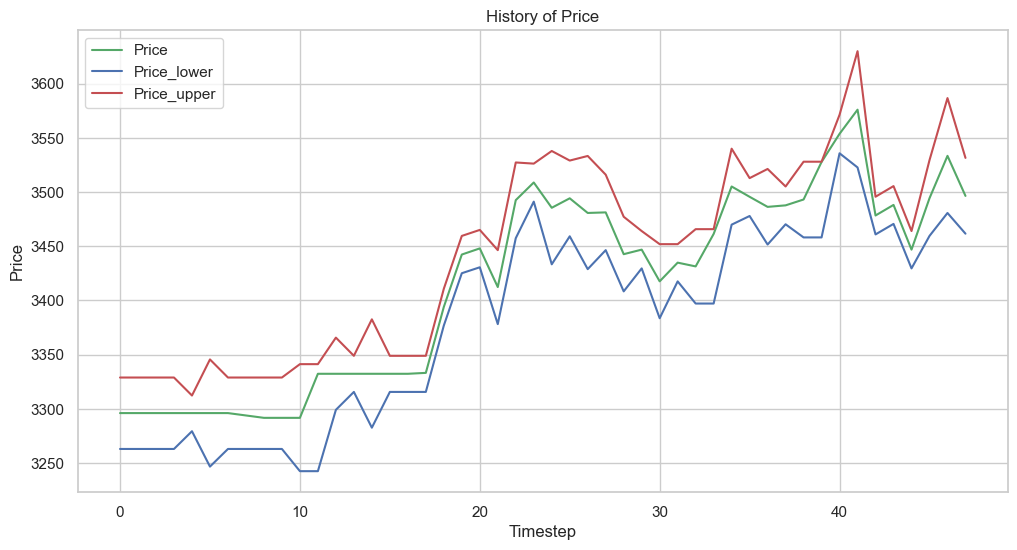

In [16]:
plt.figure(figsize=(12, 6))

upper_index = 300

# Plot fee history
plt.plot(uni_env.p_history[0:upper_index], label='Price', color='g')

# Plot p_a history
plt.plot(uni_env.pl_history[0:upper_index], label='Price_lower', color='b')

# Plot p_b history
plt.plot(uni_env.pu_history[0:upper_index], label='Price_upper', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Price')
plt.title('History of Price')

# Add legend
plt.legend()

plt.show()

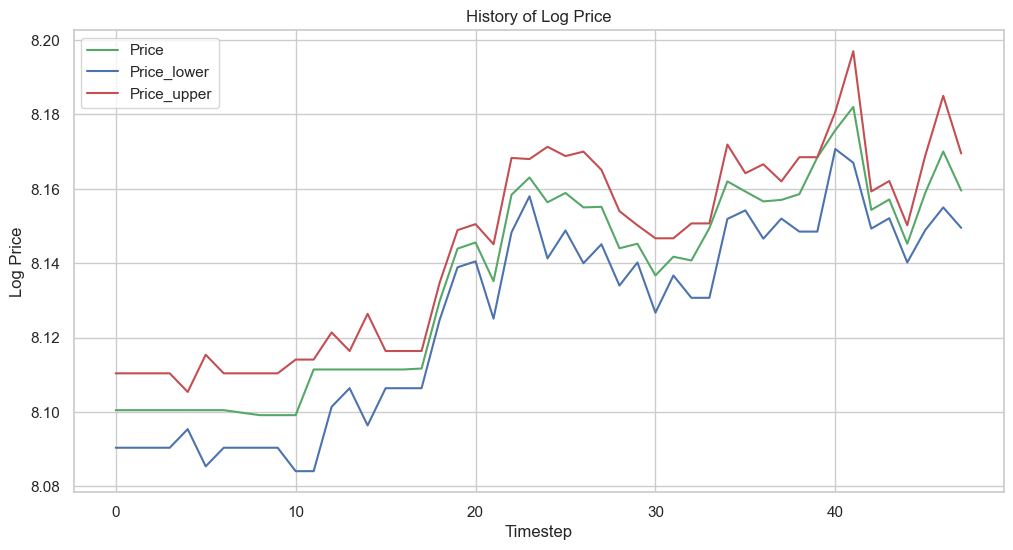

In [17]:
plt.figure(figsize=(12, 6))

log_p_history = np.log(uni_env.p_history[0:upper_index])
log_pl_history = np.log(uni_env.pl_history[0:upper_index])
log_pu_history = np.log(uni_env.pu_history[0:upper_index])


# Plot fee history
plt.plot(log_p_history, label='Price', color='g')

# Plot p_a history
plt.plot(log_pl_history, label='Price_lower', color='b')

# Plot p_b history
plt.plot(log_pu_history, label='Price_upper', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Price')
plt.title('History of Log Price')

# Add legend
plt.legend()

plt.show()

## Testing

In [34]:

# Define the length of the test data
uni_test_length = len(uni_test)

# Create the test environment
test_env = Uniswapv3Env(delta=0.05, n_actions=4, market_data=uni_test, x=2, gas=20)

# Load the trained model
rlmodel = PPO.load('ppo_custom_env')

obs, _ = test_env.reset()

results = []

# Run the test
for step in range(uni_test_length):
    action, _states = rlmodel.predict(obs, deterministic=False)
    obs, rewards, done, truncated, info = test_env.step(action)
    results.append((obs, action, rewards))

    if done:
        # obs, _ = test_env.reset()
        break

# for result in results:
#     print(result)

p_u:  1612.8058734099732  p_l:  1580.8717581833864
Initial x:  15
Initial liquidity:  120254.64084074332
Initial y:  23979.405193710325
89 Truncated here 0.008409056964877187 Liquidity
92 Truncated here 0.008807916819494785 Liquidity
94 Truncated here 0.004862194658623238 Liquidity
95 Truncated here 0.004862194658623238 Liquidity
96 Truncated here 0.00408579658290143 Liquidity
97 Truncated here 0.00408579658290143 Liquidity
98 Truncated here 0.0027236529393223777 Liquidity
99 Truncated here 0.0030509737007156437 Liquidity
100 Truncated here 0.0030509737007156437 Liquidity
101 Truncated here 0.0015382767494846127 Liquidity
102 Truncated here 0.004875589711048128 Liquidity
103 Truncated here 0.0009339841277199123 Liquidity
104 Truncated here 0.0012639861537102018 Liquidity
105 Truncated here 0.0016451831679498417 Liquidity
106 Truncated here 0.0016451831679498417 Liquidity
107 Truncated here 0.0016232383314738644 Liquidity
108 Truncated here 0.002243421780619506 Liquidity
109 Truncated h

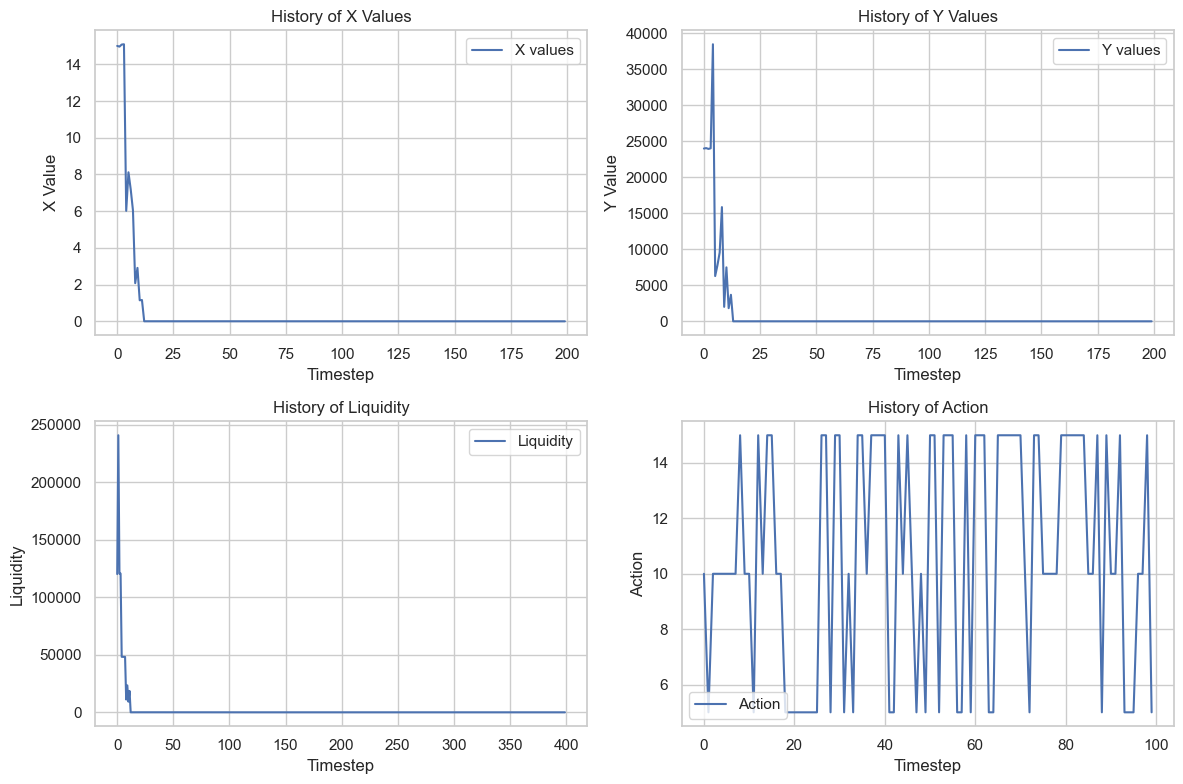

In [35]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(test_env.x_history[0:200], label='X values')
plt.title('History of X Values')
plt.xlabel('Timestep')
plt.ylabel('X Value')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(test_env.y_history[0:200], label='Y values')
plt.title('History of Y Values')
plt.xlabel('Timestep')
plt.ylabel('Y Value')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(test_env.l_history[0:400], label='Liquidity')
plt.title('History of Liquidity')
plt.xlabel('Timestep')
plt.ylabel('Liquidity')
plt.legend()

plt.subplot(2, 2, 4)
# plt.plot(uni_env.action_history[0:200], 'o', label='Action')
plt.plot(test_env.action_history[0:100], label='Action')
plt.title('History of Action')
plt.xlabel('Timestep')
plt.ylabel('Action')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
test_liquidity = test_env.l_history

test_x = test_env.x_history

test_intervals = test_env.action_history

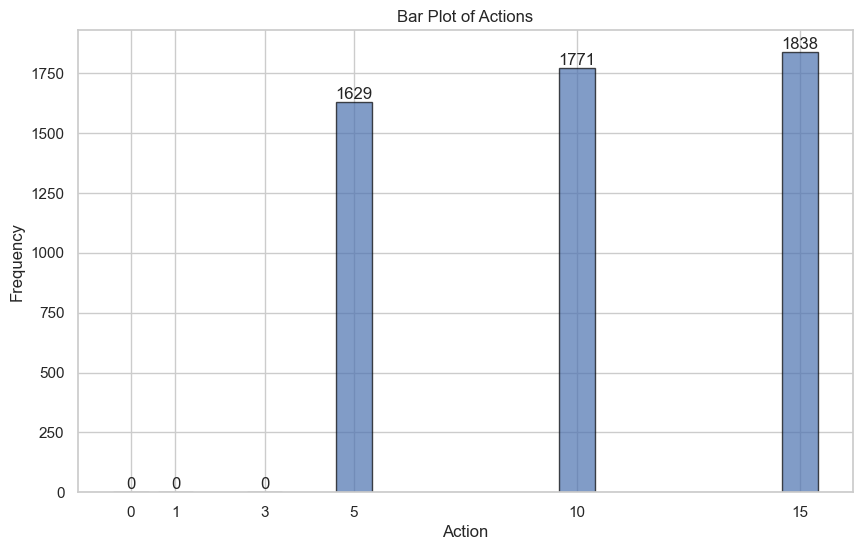

In [37]:
# Histogram for Actions (with price out correction)
action_counts = [test_env.action_history.count(action) for action in [0, 1, 3, 5, 10, 15]]

actions = [0, 1, 3, 5, 10, 15]

plt.figure(figsize=(10, 6))
bars = plt.bar(actions, action_counts, edgecolor='black', alpha=0.7)

for bar, count in zip(bars, action_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Bar Plot of Actions')
plt.xticks(actions) 

plt.show()

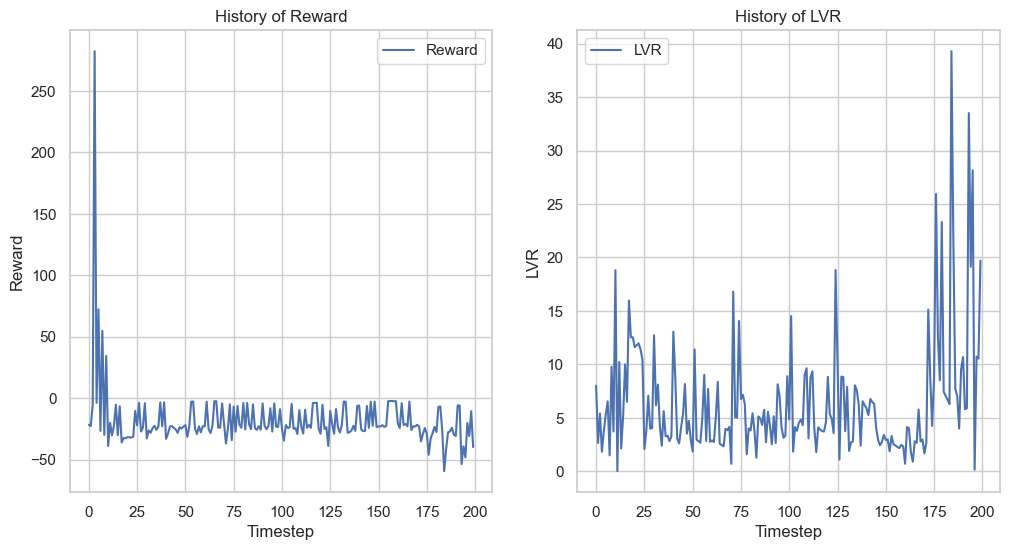

In [38]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(test_env.reward_history[0:200], label='Reward')
plt.title('History of Reward')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_env.lvr_history[0:200], label='LVR')
plt.title('History of LVR')
plt.xlabel('Timestep')
plt.ylabel('LVR')
plt.legend()


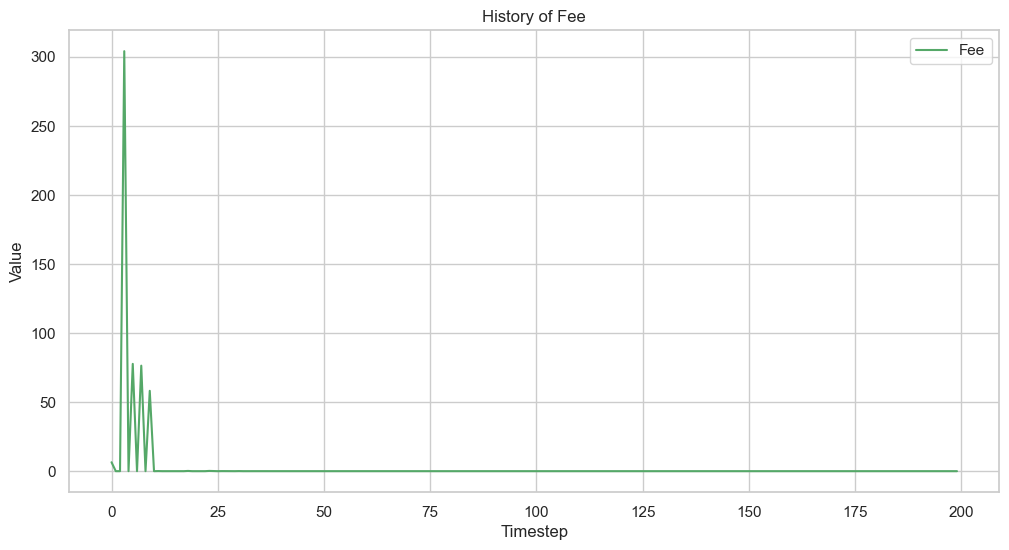

In [45]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(test_env.fee_history[0:200], label='Fee', color='g')


# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Fee')

# Add legend
plt.legend()

plt.show()

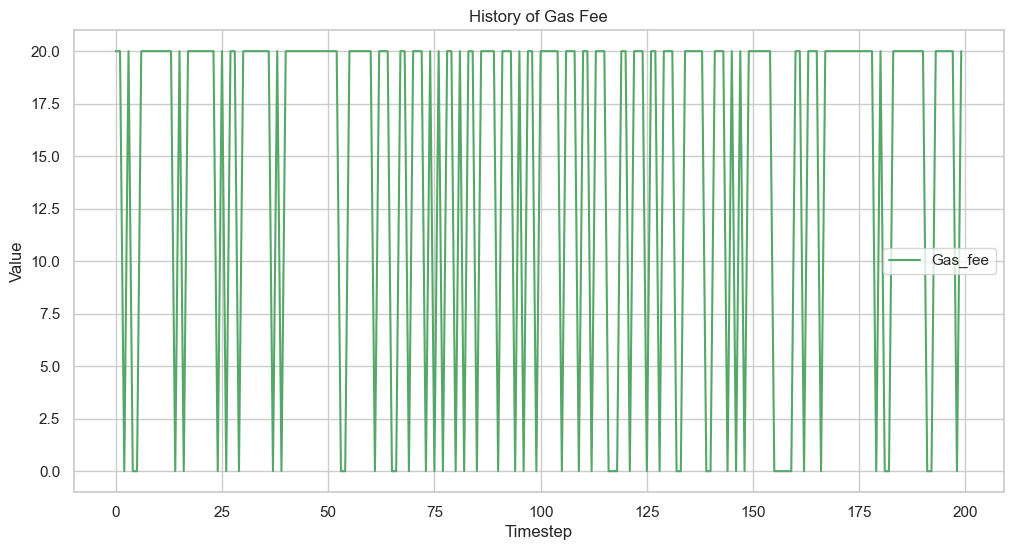

In [41]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(test_env.gas_history[0:200], label='Gas_fee', color='g')


# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Gas Fee')

# Add legend
plt.legend()

plt.show()

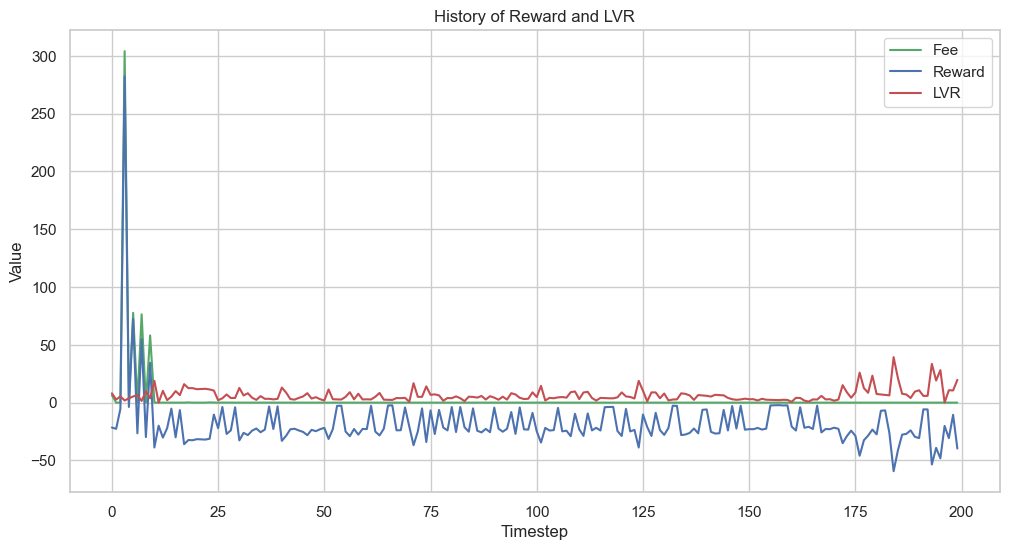

In [42]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(test_env.fee_history[0:200], label='Fee', color='g')

# Plot reward history
plt.plot(test_env.reward_history[0:200], label='Reward', color='b')

# Plot LVR history
plt.plot(test_env.lvr_history[0:200], label='LVR', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('History of Reward and LVR')

# Add legend
plt.legend()

plt.show()

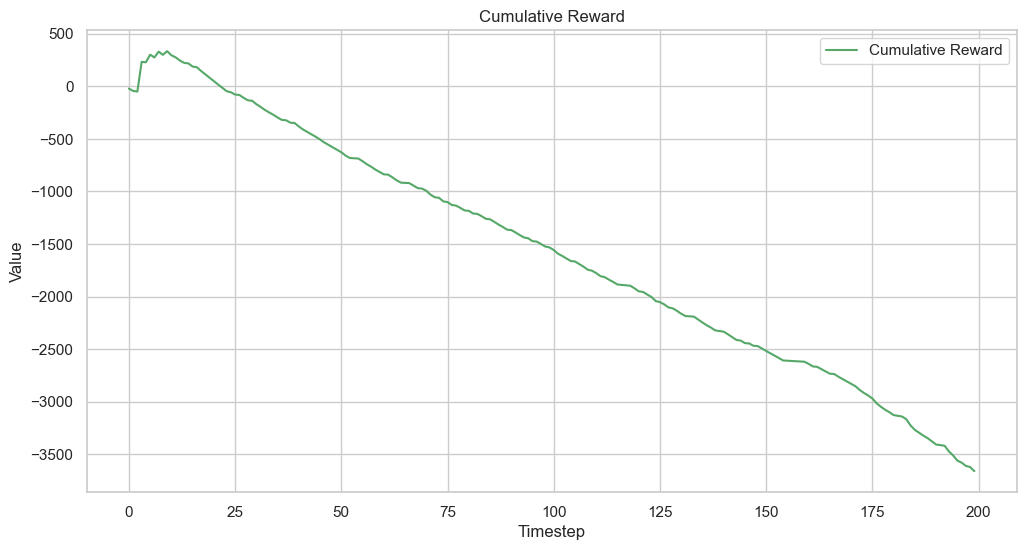

In [43]:
reward_history_np = np.array(test_env.reward_history)

cumum_reward = np.cumsum(reward_history_np)

plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(cumum_reward[0:200], label='Cumulative Reward', color='g')


# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Cumulative Reward')

# Add legend
plt.legend()

plt.show()

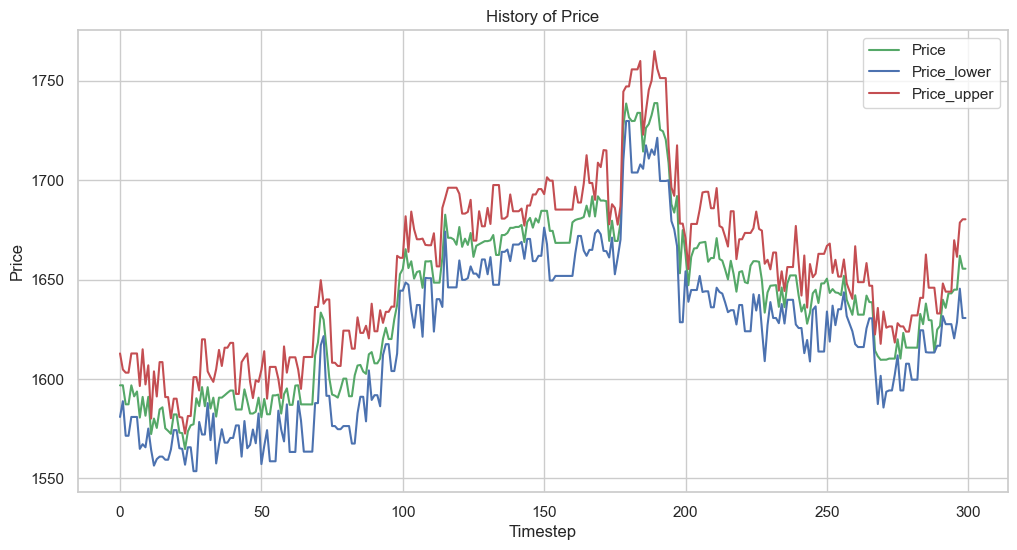

In [44]:
plt.figure(figsize=(12, 6))

# Plot fee history
plt.plot(test_env.p_history[0:upper_index], label='Price', color='g')

# Plot p_a history
plt.plot(test_env.pl_history[0:upper_index], label='Price_lower', color='b')

# Plot p_b history
plt.plot(test_env.pu_history[0:upper_index], label='Price_upper', color='r')

# Set labels and title
plt.xlabel('Timestep')
plt.ylabel('Price')
plt.title('History of Price')

# Add legend
plt.legend()

plt.show()

In [28]:
# cumulative reward
print("Training Cumulative Reward: ", uni_env.cumul_reward)
print("Testing Cumulative Reward : ", test_env.cumul_reward)

Training Cumulative Reward:  3886.175649796888
Testing Cumulative Reward :  -121717.84665272936


In [29]:
# cumulative fee
print("Training Cumulative Fees: ", uni_env.cumul_fee)
print("Testing Cumulative Fees : ", test_env.cumul_fee)

Training Cumulative Fees:  5250.642561564545
Testing Cumulative Fees :  10332.477095835793


## Count Reward and Fee Multiple Times

In [30]:
# # Import environment

# # from custom_env_b1 import CustomMLPFeatureExtractor, Uniswapv3Env

# # Initialize storage for results
# training_cumul_rewards = []
# training_cumul_fees = []
# testing_cumul_rewards = []
# testing_cumul_fees = []

# # Define the number of iterations
# n_iterations = 2

# for i in range(n_iterations):
#     uni_env = Uniswapv3Env(delta=0.05, n_actions=4, market_data=uni_train, x=2, gas=20)

#     action = 1
#     uni_env.reset()
#     uni_env.step(action)

#     # Define policy_kwargs with the custom feature extractor
#     policy_kwargs = dict(
#         features_extractor_class=CustomMLPFeatureExtractor,
#         features_extractor_kwargs=dict(features_dim=128),  # This dimension will be the output of the feature extractor
#     )

#     # Create the PPO model with the custom MLP policy and feature extractor
#     rlmodel = PPO("MlpPolicy", uni_env, policy_kwargs=policy_kwargs, verbose=2)
#     rlmodel.learn(total_timesteps=10000)
#     rlmodel.save("ppo_custom_env")
#     training_cumul_rewards.append(uni_env.cumul_reward)
#     training_cumul_fees.append(uni_env.cumul_fee)
    
#     ''' 
#     Testing
#     '''
#     # Define the length of the test data
#     uni_test_length = len(uni_test)
#     test_env = Uniswapv3Env(delta=0.05, n_actions=4, market_data=uni_test, x=2, gas=20)
#     rlmodel = PPO.load('ppo_custom_env')
#     obs, _ = test_env.reset()
#     results = []

#     # Run the test
#     for step in range(uni_test_length):
#         action, _states = rlmodel.predict(obs, deterministic=False)
#         obs, rewards, done, truncated, info = test_env.step(action)
#         results.append((obs, action, rewards))

#         if done:
#             obs, _ = test_env.reset()
#             break
        
#     testing_cumul_rewards.append(test_env.cumul_reward)
#     testing_cumul_fees.append(test_env.cumul_fee)


# # Create a DataFrame to store results
# cumul_df = pd.DataFrame({
#     'Training Cumulative Reward': training_cumul_rewards,
#     'Training Cumulative Fee': training_cumul_fees,
#     'Testing Cumulative Reward': testing_cumul_rewards,
#     'Testing Cumulative Fee': testing_cumul_fees
# })

p_u:  3328.890975231183  p_l:  3262.977780263077
Initial x:  15
Initial liquidity:  174312.836287775
Initial y:  50379.63582864693
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
p_u:  3312.2888902438453  p_l:  3279.3327046717786
Initial x:  15
Initial liquidity:  351535.0906592234
Initial y:  51338.468533633204
149 Truncated here 0.008222292679135514 Liquidity
p_u:  3345.5762743447813  p_l:  3246.7044223120974
Initial x:  15
Initial liquidity:  115985.90686066775
Initial y:  50064.06729175771
99 Truncated here 0.00915478388940264 Liquidity
p_u:  3328.890975231183  p_l:  3262.977780263077
Initial x:  15
Initial liquidity:  174312.836287775
Initial y:  50379.63582864693
207 Truncated here 0.0077005953362164 Liquidity
p_u:  3345.5762743447813  p_l:  3246.7044223120974
Initial x:  15
Initial liquidity:  115985.90686066775
Initial y:  50064.06729175771
159 Truncated here 0.0066048492589700575 Liquidity
p_u:  3345.5762743447813  p_l:  3246.70442

In [31]:
# Display the results
print(cumul_df)

   Training Cumulative Reward  Training Cumulative Fee  \
0                 4613.372383              6776.812028   
1                59066.512678             61654.903607   

   Testing Cumulative Reward  Testing Cumulative Fee  
0                          0                       0  
1                          0                       0  


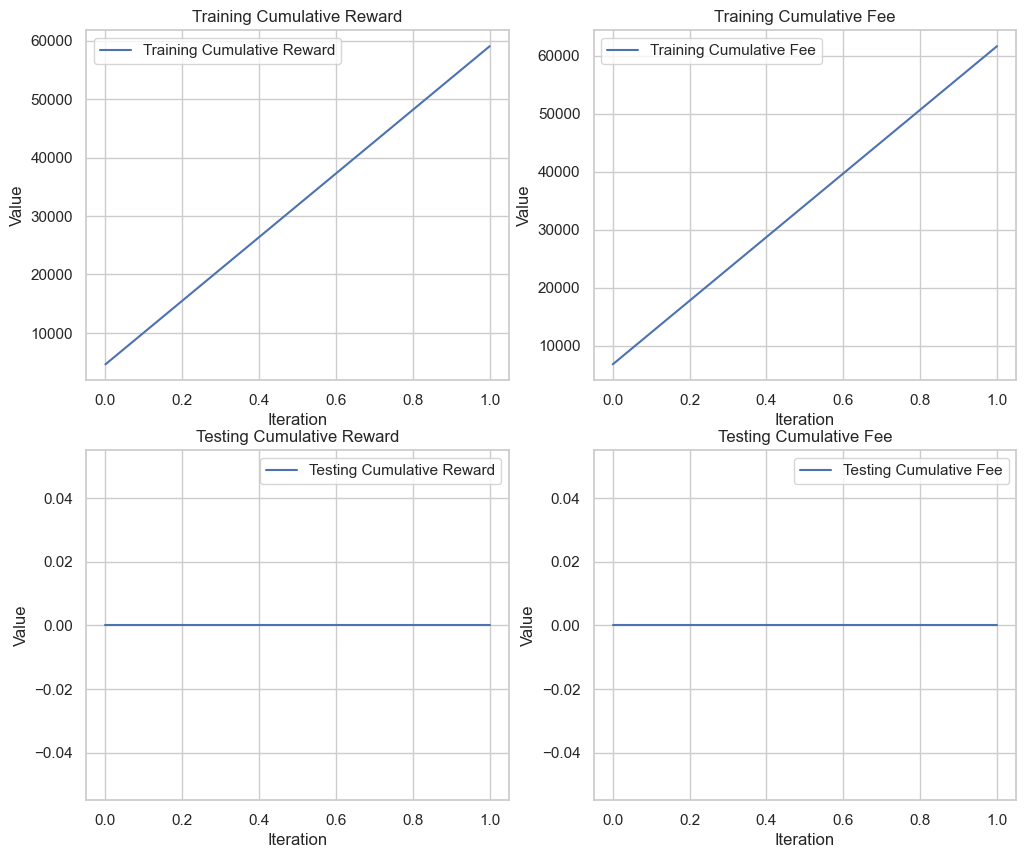

In [32]:
# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(training_cumul_rewards, label='Training Cumulative Reward')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Training Cumulative Reward')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_cumul_fees, label='Training Cumulative Fee')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Training Cumulative Fee')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(testing_cumul_rewards, label='Testing Cumulative Reward')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Testing Cumulative Reward')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(testing_cumul_fees, label='Testing Cumulative Fee')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Testing Cumulative Fee')
plt.legend()

plt.show()